In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers
import shutil

tf.VERSION

W0521 23:40:43.265540 140298114369344 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.12.0'

In [ ]:
import os
import glob 
import json
files = glob.glob("collection_19_may/*.jpg")
jsons = glob.glob("collection_19_may/*.json")
if not os.path.exists("sorted"):
 os.mkdir("sorted");

print("There are {} images".format(len(files)))
for data in jsons:
    with open(data) as f:
        j = json.load(f)
        steering=j["angular"]["z"]
        json_dir=os.path.dirname(data)
        image_path=os.path.basename(data).split(".")[0]+".jpg"
        print(image_path)
        rounded_steering=round(steering,1)
        print(rounded_steering)

        if not os.path.exists(os.path.join('sorted',str(rounded_steering))):
            os.mkdir(os.path.join('sorted',str(rounded_steering)));
  
        shutil.copy(os.path.join(json_dir,image_path), os.path.join('sorted',format(rounded_steering)))  


#df[""]
# df["steer"] = df["file"].replace(to_replace="(.*)?leftimage_", value="", regex=True)
# df["steer"] = df["steer"].replace(to_replace=".jpg", value="", regex=True)
# df["steer"] = pd.to_numeric(df["steer"])

In [2]:
data_root = "/home/tom/.keras/datasets/flower_photos"
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


In [3]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break
print(data_root)

Image batch shape:  (32, 256, 256, 3)
Label batch shape:  (32, 5)
/home/tom/.keras/datasets/flower_photos


In [4]:
#classifier_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/3" #@param {type:"string"}
#classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/3"  #@param {type:"string"}

def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

In [5]:
#feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/3" #@param {type:"string"}
#feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/3" #@param {type:"string"}

def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False


Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [7]:
class FeatureLayer(tf.layers.Layer):
    def __init__(self, **kwargs):
        self.trainable = False
        super(FeatureLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.feature_vector = hub.Module(
            "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/3",
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        super(FeatureLayer, self).build(input_shape)

    def call(self, inputs):
        results = self.feature_vector(inputs=inputs)
        return results

fv_input = tf.keras.layers.Input(shape=(224, 224, 3))
fv_output = FeatureLayer()(fv_input)
x = tf.keras.layers.Dense(1024, activation='relu')(fv_output)
x = tf.keras.layers.Dense(5, activation='sigmoid')(x)
model = tf.keras.Model(fv_input, x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 23:41:34.096967 140298114369344 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 23:41:35.746525 140298114369344 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [8]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

print("Number of classes is {}".format(image_data.num_classes))

# model = tf.keras.Sequential([
#   features_extractor_layer,
#   layers.Dense(image_data.num_classes, activation='softmax')
# ])
model.summary()
init = tf.global_variables_initializer()
sess.run(init)
result = model.predict(image_batch)
result.shape

Number of classes is 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
feature_layer_2 (FeatureLaye (None, 1792)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1836032   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 1,841,157
Trainable params: 1,841,157
Non-trainable params: 0
_________________________________________________________________


(32, 5)

In [9]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=4, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/4
114/114 [==============================] - 13s 118ms/step - loss: 0.4209 - acc: 0.8599
Epoch 2/4
114/114 [==============================] - 11s 96ms/step - loss: 0.1808 - acc: 0.9367
Epoch 3/4
114/114 [==============================] - 12s 102ms/step - loss: 0.0987 - acc: 0.9616
Epoch 4/4
114/114 [==============================] - 11s 99ms/step - loss: 0.0527 - acc: 0.9786


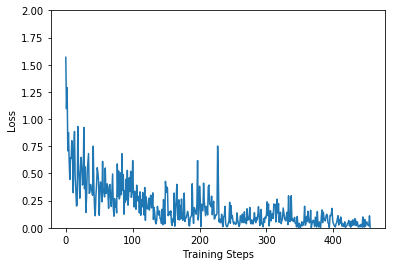

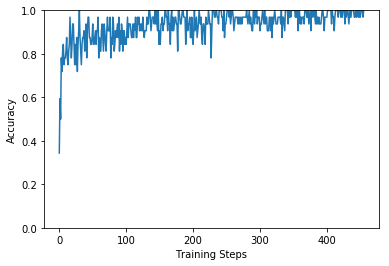

In [10]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


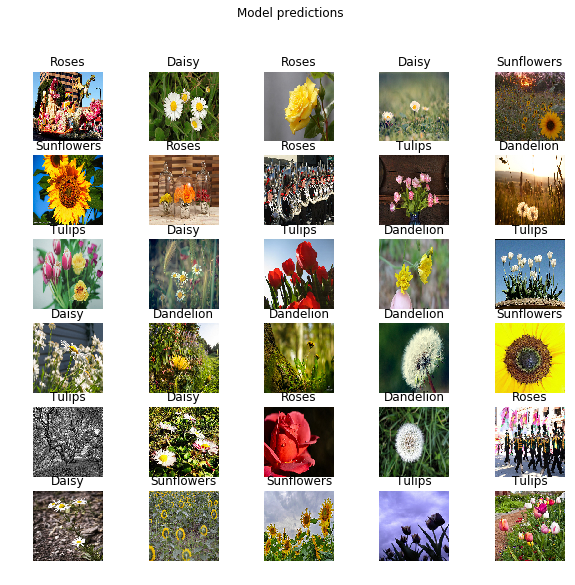

In [11]:
import numpy as np
import PIL.Image as Image
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
print(label_names)
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [13]:
# init = tf.global_variables_initializer()
# sess.run(init)

print(IMAGE_SIZE)

# result = model.predict(image_batch)
# result.shape
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
print(label_names)
# predicted_class = np.argmax(result[0], axis=-1)
# predicted_class
grace_hopper = "/home/tom/.keras/datasets/flower_photos/sunflowers/6953297_8576bf4ea3.jpg"
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

result = model.predict(grace_hopper[np.newaxis, ...])
result.shape
print(result[0])

print(label_names[np.argmax(result[0], axis=-1)])


[224, 224]
['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']
[7.0862228e-08 3.9922885e-05 8.7732263e-07 6.3021612e-01 1.0473772e-06]
Sunflowers


In [14]:
model.save('my_new_model.h5')
tf.contrib.saved_model.save_keras_model
saved_to_path = tf.contrib.saved_model.save_keras_model(
      model, './new/saved')
print(saved_to_path)

W0521 23:44:32.080220 140298114369344 tf_logging.py:125] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 23:44:36.136597 140298114369344 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 23:44:37.406164 140298114369344 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


I0521 23:44:38.605752 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0521 23:44:38.618127 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0521 23:44:38.619425 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0521 23:44:38.621182 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0521 23:44:38.622660 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Classify: None


W0521 23:44:38.623689 140298114369344 tf_logging.py:120] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0521 23:44:38.657401 140298114369344 tf_logging.py:115] No assets to save.


INFO:tensorflow:No assets to write.


I0521 23:44:38.658284 140298114369344 tf_logging.py:115] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 23:44:39.757700 140298114369344 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 23:44:41.039751 140298114369344 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0521 23:44:41.701690 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


I0521 23:44:41.702683 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Eval: ['eval']


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0521 23:44:41.703390 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0521 23:44:41.704109 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0521 23:44:41.705181 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Classify: None


W0521 23:44:41.706206 140298114369344 tf_logging.py:120] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0521 23:44:41.730849 140298114369344 tf_logging.py:115] No assets to save.


INFO:tensorflow:No assets to write.


I0521 23:44:41.731795 140298114369344 tf_logging.py:115] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 23:44:42.909909 140298114369344 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0521 23:44:44.143735 140298114369344 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0521 23:44:44.718200 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0521 23:44:44.719146 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0521 23:44:44.719847 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0521 23:44:44.720508 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0521 23:44:44.721212 140298114369344 tf_logging.py:115] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:No assets to save.


I0521 23:44:44.739528 140298114369344 tf_logging.py:115] No assets to save.


INFO:tensorflow:No assets to write.


I0521 23:44:44.740874 140298114369344 tf_logging.py:115] No assets to write.


INFO:tensorflow:SavedModel written to: ./new/saved/temp-b'1558446274'/saved_model.pb


I0521 23:44:45.348667 140298114369344 tf_logging.py:115] SavedModel written to: ./new/saved/temp-b'1558446274'/saved_model.pb


b'./new/saved/1558446274'


In [ ]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")

export_path

In [ ]:
#export_path="./saved_models/1558363131"
#model_prime = tf.contrib.saved_model.load_keras_model(export_path)
#model_prime.summary()
#model_prime.save_weights('./checkpoints/my_checkpoint')


In [ ]:

# import tensorflow.keras.backend as K
# sess = K.get_session()
init = tf.global_variables_initializer()
sess.run(init)


In [ ]:
print(IMAGE_SIZE)

# result = model.predict(image_batch)
# result.shape
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
print(label_names)
# predicted_class = np.argmax(result[0], axis=-1)
# predicted_class
grace_hopper = "/home/tom/.keras/datasets/flower_photos/sunflowers/44079668_34dfee3da1_n.jpg"
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

result = model.predict(grace_hopper[np.newaxis, ...])
result.shape
print(result[0])

print(label_names[np.argmax(result[0], axis=-1)])

# model_prime.predict('/home/tom/Documents/bots/pictures/MIT/03.jpg')

In [ ]:
# from keras.models import load_model

model_prime.save('my_model_keras.h5')  # creates a HDF5 file 'my_model.h5'
# tf.keras.models.save_model(
#     model_prime,
#     'my_model.h5',
#     overwrite=True,
#     include_optimizer=True
# )

In [ ]:
model_keras = tf.keras.models.load_model('my_model_keras.h5')
